# Stock Price Predictor

#### Model will be trained on TCS stock price historical data taken from Yahoo finance

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import statsmodels.api as sm
%matplotlib inline

#### Load data

In [85]:
df = pd.read_csv('TcsMo.csv',header=[0],parse_dates=[0])

In [86]:
dfr=pd.DataFrame(df,columns=['Date','Close','Volume'])
dfr.index = dfr['Date']

In [135]:
train =dfr.ix['2005-01-01':'2018-12-31']
val =dfr.ix['2019-01-01':'2019-12-31']

#### Check for trend and Seasonality

In [144]:
from statsmodels.tsa.seasonal import seasonal_decompose

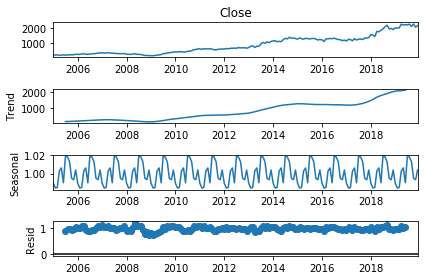

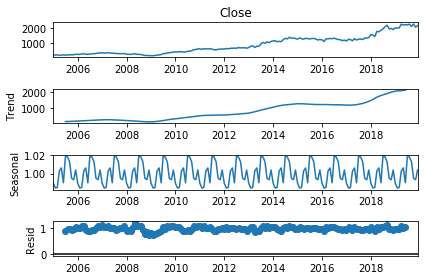

In [145]:
result = seasonal_decompose(dfr['Close'], model='multiplicative')

result.plot()

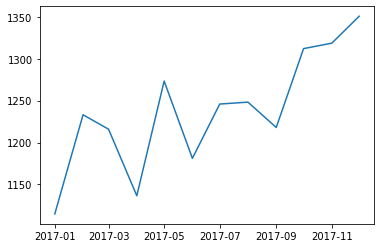

In [146]:
#zoom
plt.plot(train['Close']['2017-01-01':'2017-12-31'])

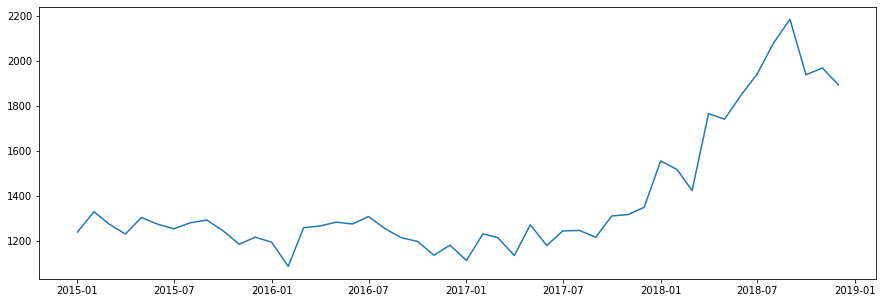

In [91]:
plt.figure(figsize=(15,5))
plt.plot(train['Close']['2015-01-01':'2018-12-31'])

#### SARIMAX Model

In [92]:
import statsmodels.graphics as sg
from statsmodels.graphics.tsaplots import plot_pacf

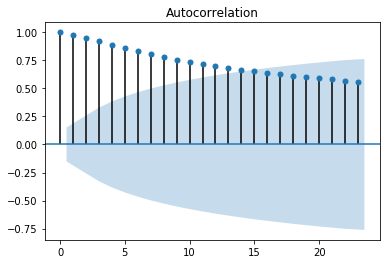

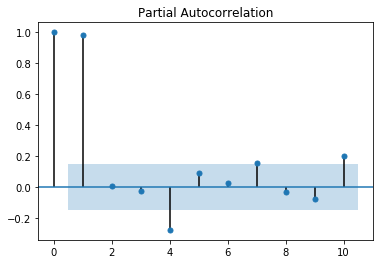

In [93]:
lag_acf = sg.tsaplots.plot_acf(train['Close'].dropna())
lag_pacf=plot_pacf(train['Close'].dropna(),lags=10)

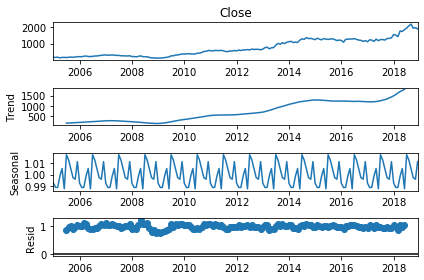

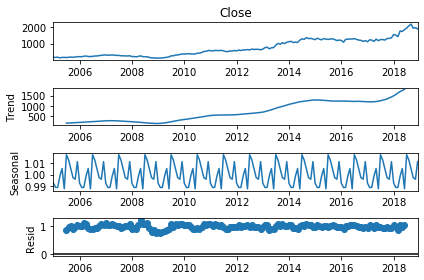

In [108]:
seasonal_decompose(train['Close'], model='multiplicative').plot()

In [18]:
#p=1,q=13,P=1,q=3

In [150]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [152]:
model = SARIMAX(train['Close'], order=(1,1,11), seasonal_order=(1,2,3,12))
model_fit = model.fit()

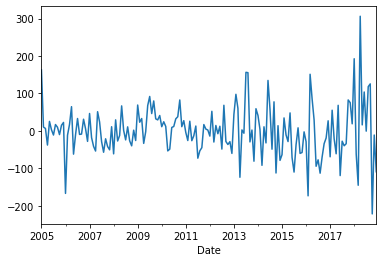

In [103]:
residuals = model_fit.resid
residuals.plot()

In [109]:
yhat = val.copy()
yhat['SARIMA'] = model_fit.forecast(len(val))

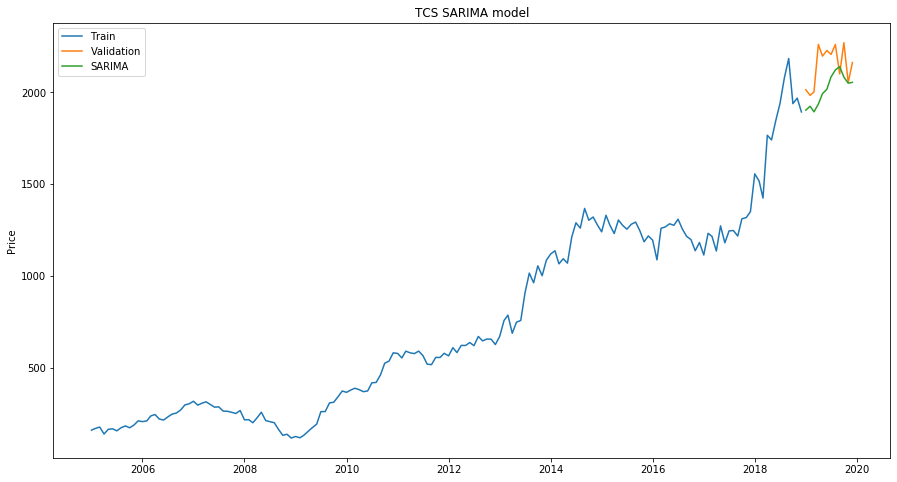

In [153]:
plt.figure(figsize=(15,8))
plt.plot(train.Close,label='Train')
plt.plot(val.Close,label='Validation')
plt.plot(yhat['SARIMA'],label='SARIMA')
plt.ylabel('Price')
plt.title('TCS SARIMA model')
plt.legend(loc='best')

In [111]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(val.Close, yhat.SARIMA)
mse

25162.94435772709

#### SARIMA with Exogenous Variables

In [138]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [139]:
model2 = SARIMAX(train['Close'], order=(1,2,11), seasonal_order=(1,2,3,12),exog=train['Volume'])

In [140]:
model_fit2 = model2.fit()

In [141]:
exog_forecast = pd.DataFrame(val['Volume'],index=val.index)

In [142]:
yhat['SARIMAx'] = model_fit2.forecast(len(val),exog=exog_forecast)

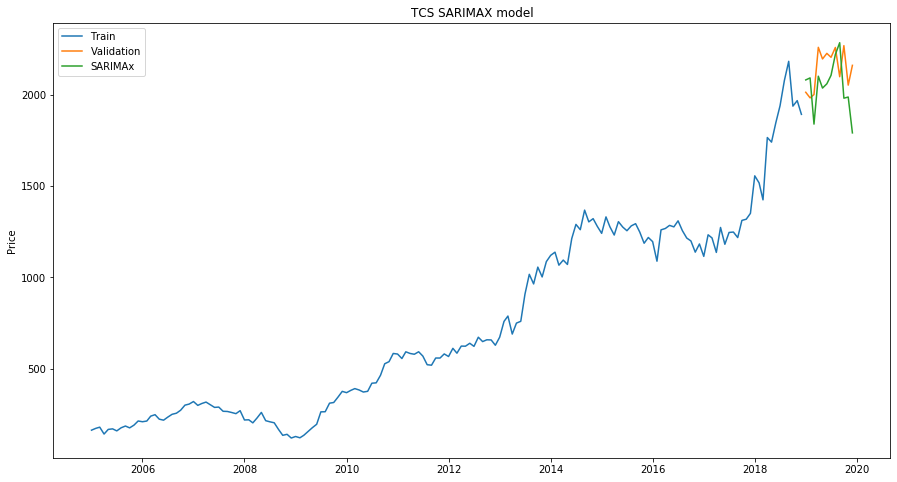

In [154]:
plt.figure(figsize=(15,8))
plt.plot(train.Close,label='Train')
plt.plot(val.Close,label='Validation')
plt.plot(yhat['SARIMAx'],label='SARIMAx')
plt.ylabel('Price')
plt.title('TCS SARIMAX model')
plt.legend(loc='best')

#### Auto ARIMA

In [112]:
import pmdarima as pm

In [113]:
from pmdarima.arima.utils import ndiffs

# Estimate the number of differences using an ADF test:
n_adf = ndiffs(train.Close, test='adf')  

# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(train.Close, test='kpss') 

In [114]:
n_diffs = max(n_adf, n_kpss)
n_diffs

1

In [115]:
auto = pm.auto_arima(train.Close, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1846.459, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1839.419, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1840.576, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1849.338, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1841.408, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1841.415, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.331, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1845.032, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.976 seconds


In [116]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

In [117]:
model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in val.Close:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(val.Close, forecasts)}")
print(f"SMAPE: {smape(val.Close, forecasts)}")

Mean squared error: 12268.72901758412
SMAPE: 3.620017876747937


In [118]:
future = pd.Series(forecasts,index=val.index)

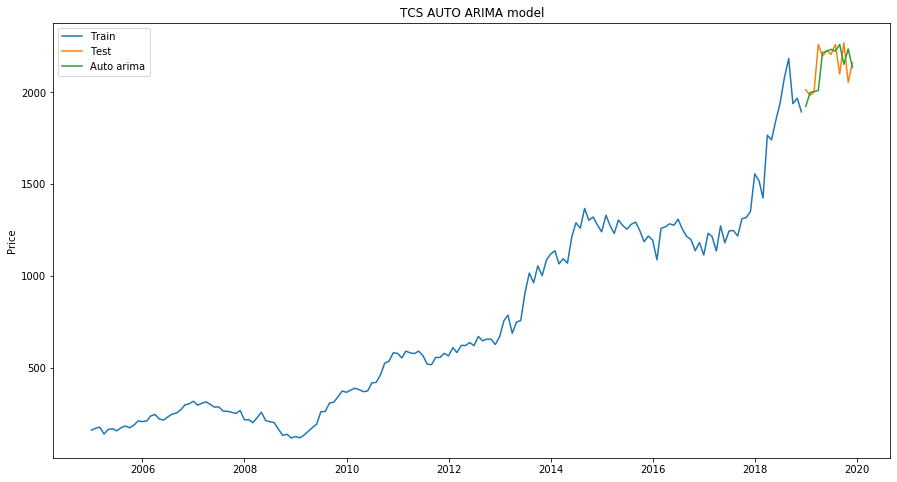

In [155]:
plt.figure(figsize=(15,8))
plt.plot(train.Close,label='Train')
plt.plot(val.Close,label='Test')
plt.plot(future,label='Auto arima')
plt.ylabel('Price')
plt.title('TCS AUTO ARIMA model')
plt.legend(loc='best')

#### Auto SARIMA 

In [156]:
from pmdarima.datasets import load_lynx
from pmdarima.arima.utils import nsdiffs

In [123]:
# estimate number of seasonal differences using a Canova-Hansen test
D = nsdiffs(train.Close,
            m=12,  # commonly requires knowledge of dataset
            max_D=12,
            test='ch')  # -> 0



In [124]:
# or use the OCSB test (by default)
nsdiffs(train.Close,
        m=10,
        max_D=12,
        test='ocsb')  # -> 0

0

In [130]:
m12 = pm.auto_arima(train.Close, error_action='ignore', seasonal=True, m=12)

In [126]:
future=m12.predict(len(val))
future = pd.Series(forecasts,index=val.index)

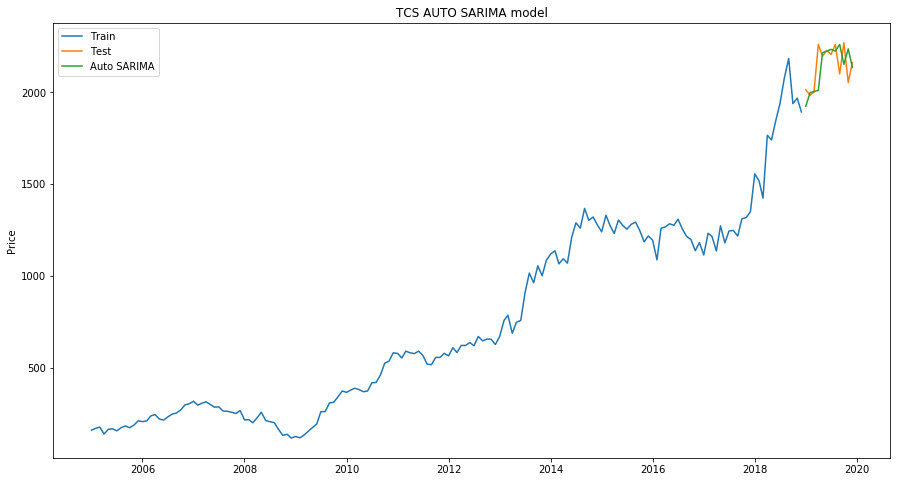

In [157]:
plt.figure(figsize=(15,8))
plt.plot(train.Close,label='Train')
plt.plot(val.Close,label='Test')
plt.plot(future,label='Auto SARIMA')
plt.ylabel('Price')
plt.title('TCS AUTO SARIMA model')
plt.legend(loc='best')

In [129]:
print(f"Mean squared error: {mean_squared_error(val.Close, future)}")
print(f"SMAPE: {smape(val.Close, future)}")

Mean squared error: 12268.72901758412
SMAPE: 3.620017876747937
